Principais Verificações que este EDA faz:

- Consistência dimensional: Verifica se todas as imagens têm as mesmas dimensões
- Alinhamento imagem-label: Confirma correspondência entre imagens e máscaras
- Distribuição de intensidades: Analisa características dos voxels
- Qualidade das labels: Verifica continuidade e volume das segmentações
- Resolução espacial: Analisa consistência no tamanho dos voxels
- Visualização: Permite inspecionar visualmente amostras

Execute este código e me mostre os resultados! Isso nos ajudará a identificar possíveis problemas nos dados antes de treinar a U-Net.

RELATÓRIO COMPLETO DE EDA - IMAGENS HIPOCAMPO (min_size=80)

1. CARREGANDO DADOS...
Encontrados 260 arquivos de imagem
Encontrados 260 arquivos de label
✓ Pares encontrados: 260
✗ Imagens sem label: 0

Carregando 260 pares...

RESUMO INICIAL:
Total de imagens carregadas: 260
Total de labels carregados: 260

2. IDENTIFICANDO OUTLIERS...

IDENTIFICAÇÃO DE OUTLIERS

🔍 ANÁLISE DE COMPONENTES CONECTADOS (após limpeza com min_size=80)
------------------------------------------------------------

🔍 ANÁLISE ESPECÍFICA: hippocampus_195.nii.gz
--------------------------------------------------
Dimensões da imagem: (33, 53, 28)
Dimensões do label: (33, 53, 28)
Voxel size: (1.0, 1.0, 1.0) mm
Volume do hipocampo: 3.66 cm³
Proporção de voxels: 0.0748
Componentes conectados: 1 → 1 (após limpeza)
Tamanhos dos componentes: [3661]
Valores únicos no label: [0. 1. 2.]
❌ hippocampus_195.nii.gz identificada como outlier

📊 RESUMO DE OUTLIERS: 1 arquivos problemáticos

🔴 hippocampus_195.nii.gz
   Motivos:
  

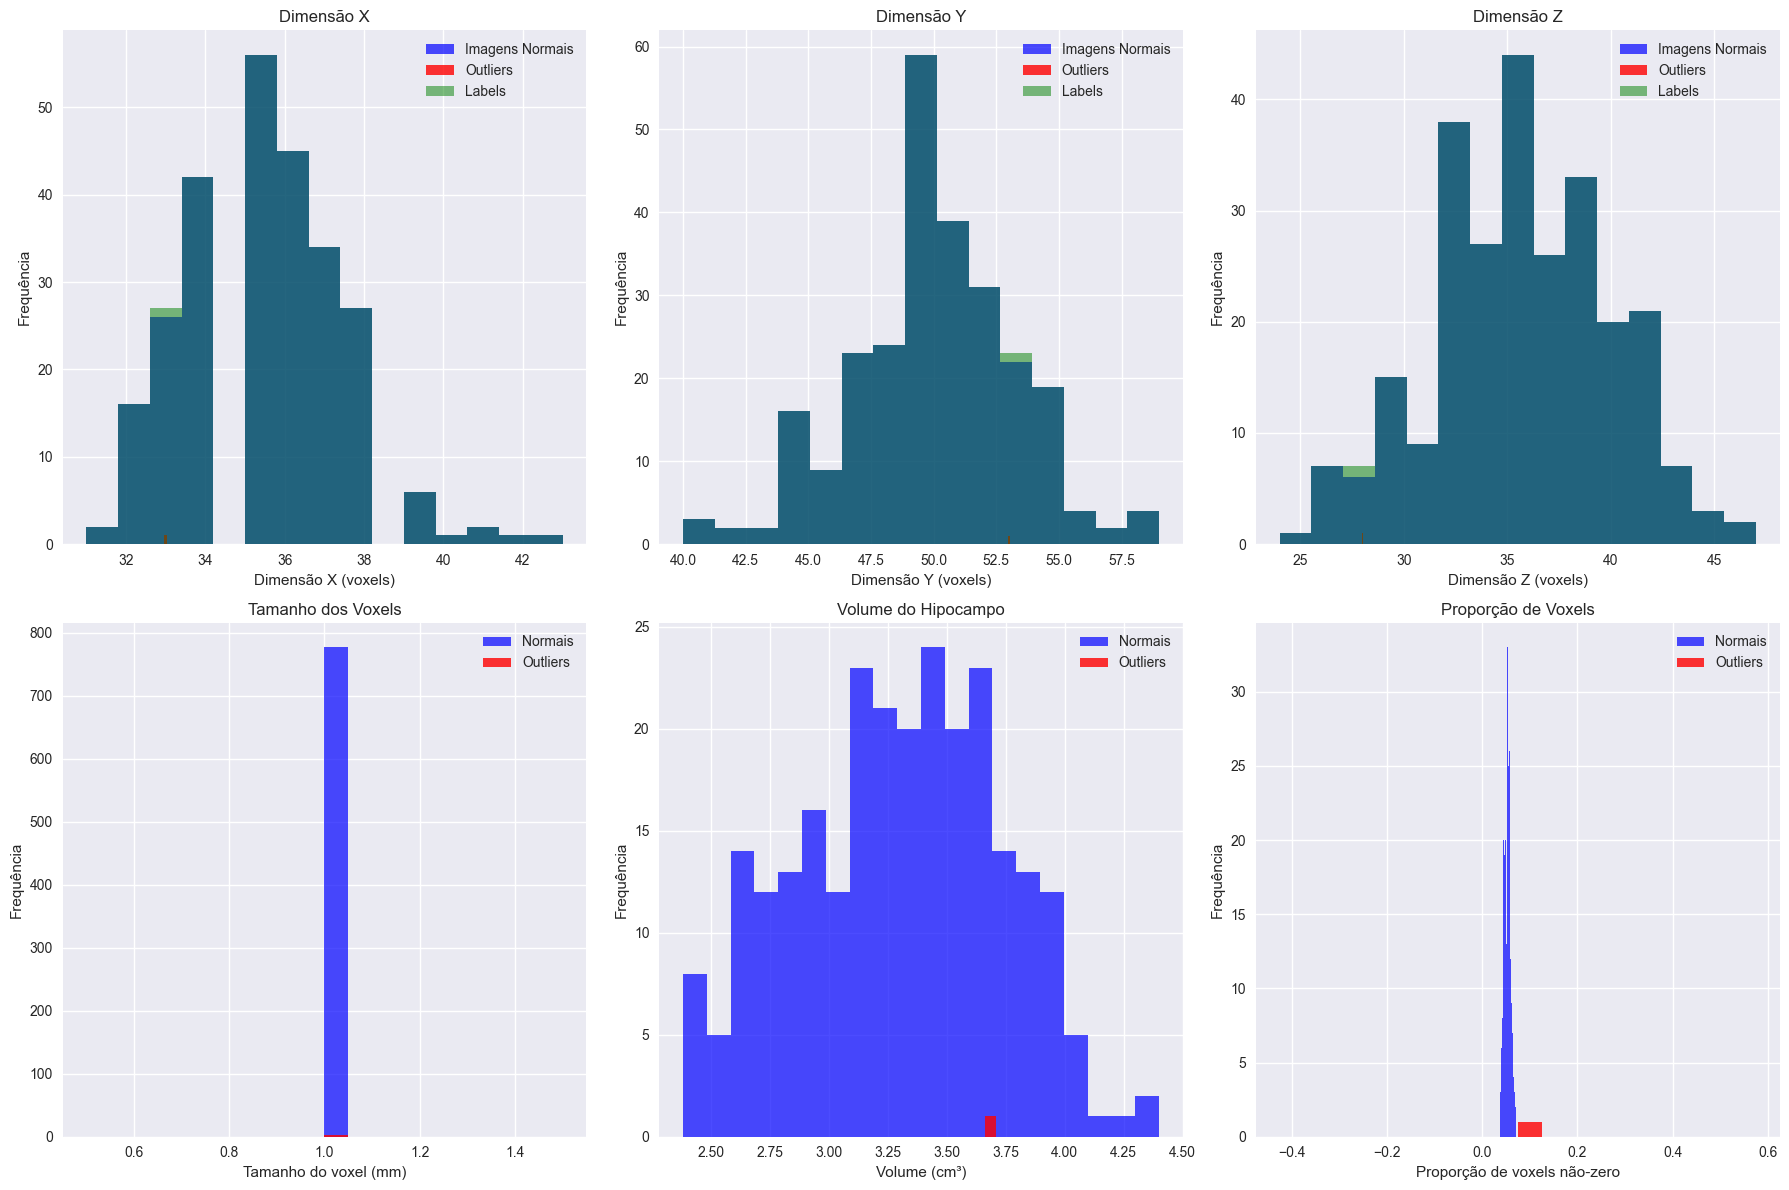


4. VERIFICANDO ALINHAMENTO...
Taxa de alinhamento: 100.0% (260/260 pares)
✓ Todos os pares estão perfeitamente alinhados!

5. ANÁLISE DE INTENSIDADES...


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_38711/3922048217.py:600: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(sample_data, labels=filenames)


Distribuição das classes nos labels:
  Classe 0.0: 15469502 voxels
  Classe 1.0: 445938 voxels
  Classe 2.0: 410816 voxels


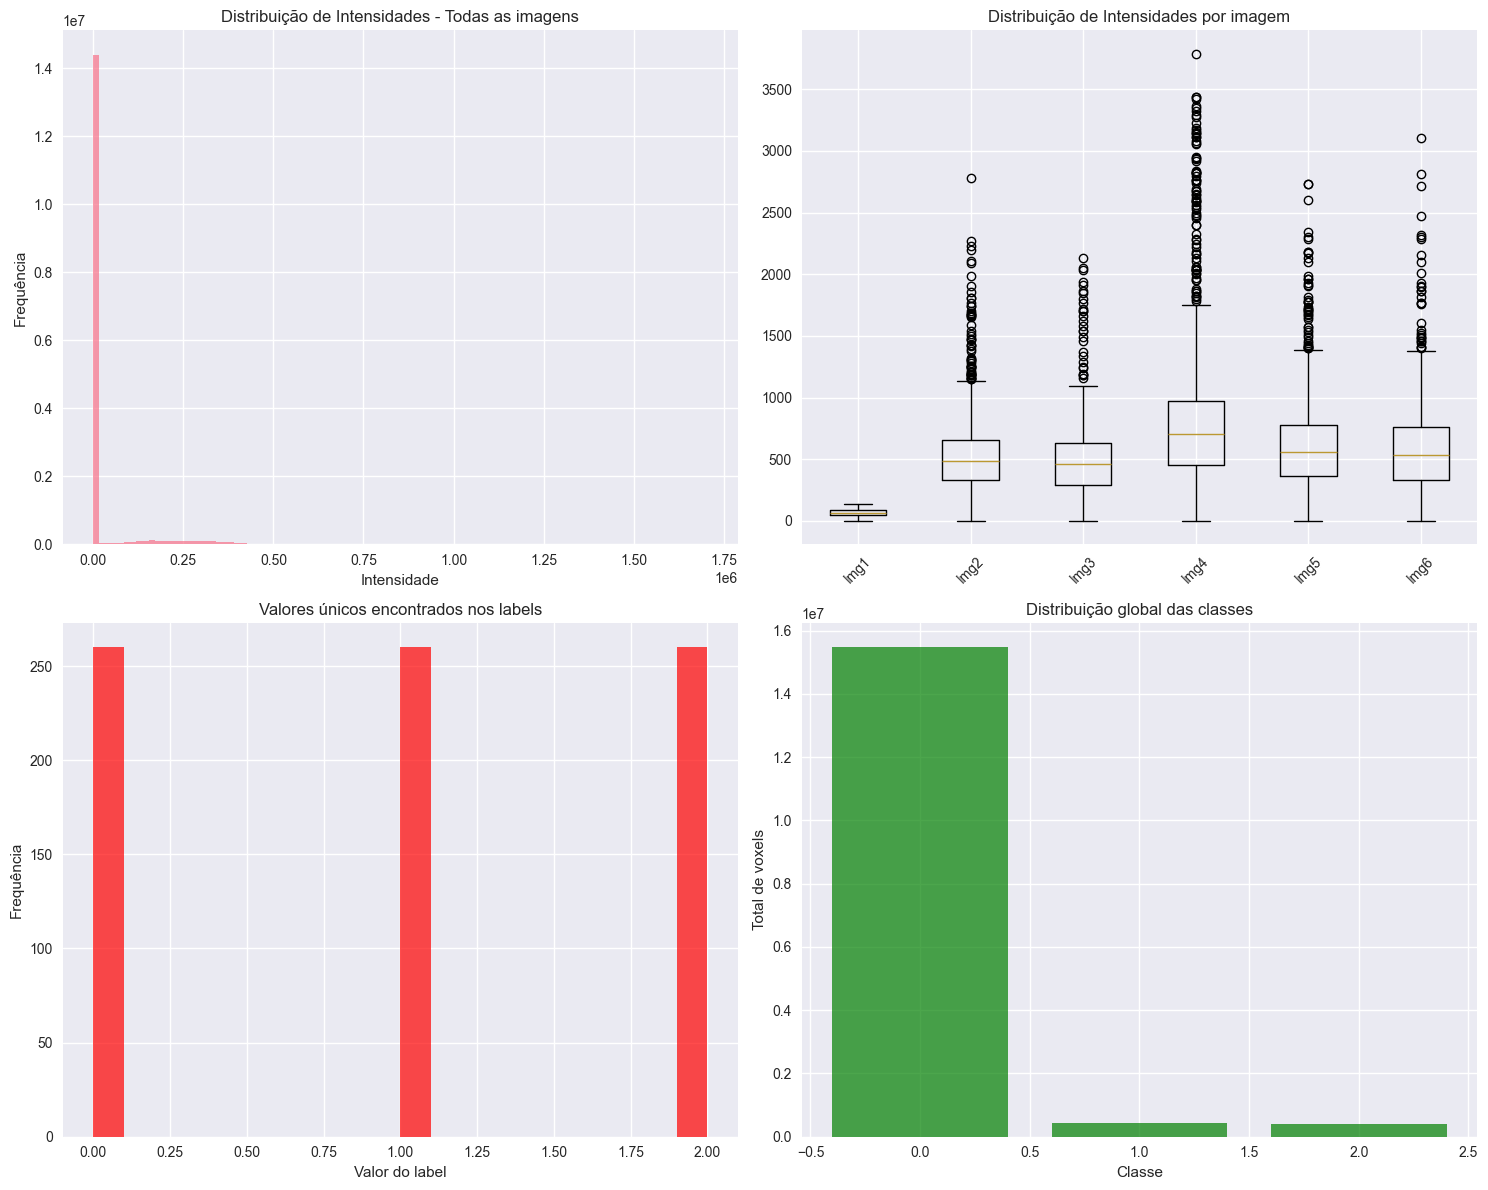


6. ANÁLISE DA QUALIDADE DA ROTULAÇÃO (min_size=80)...


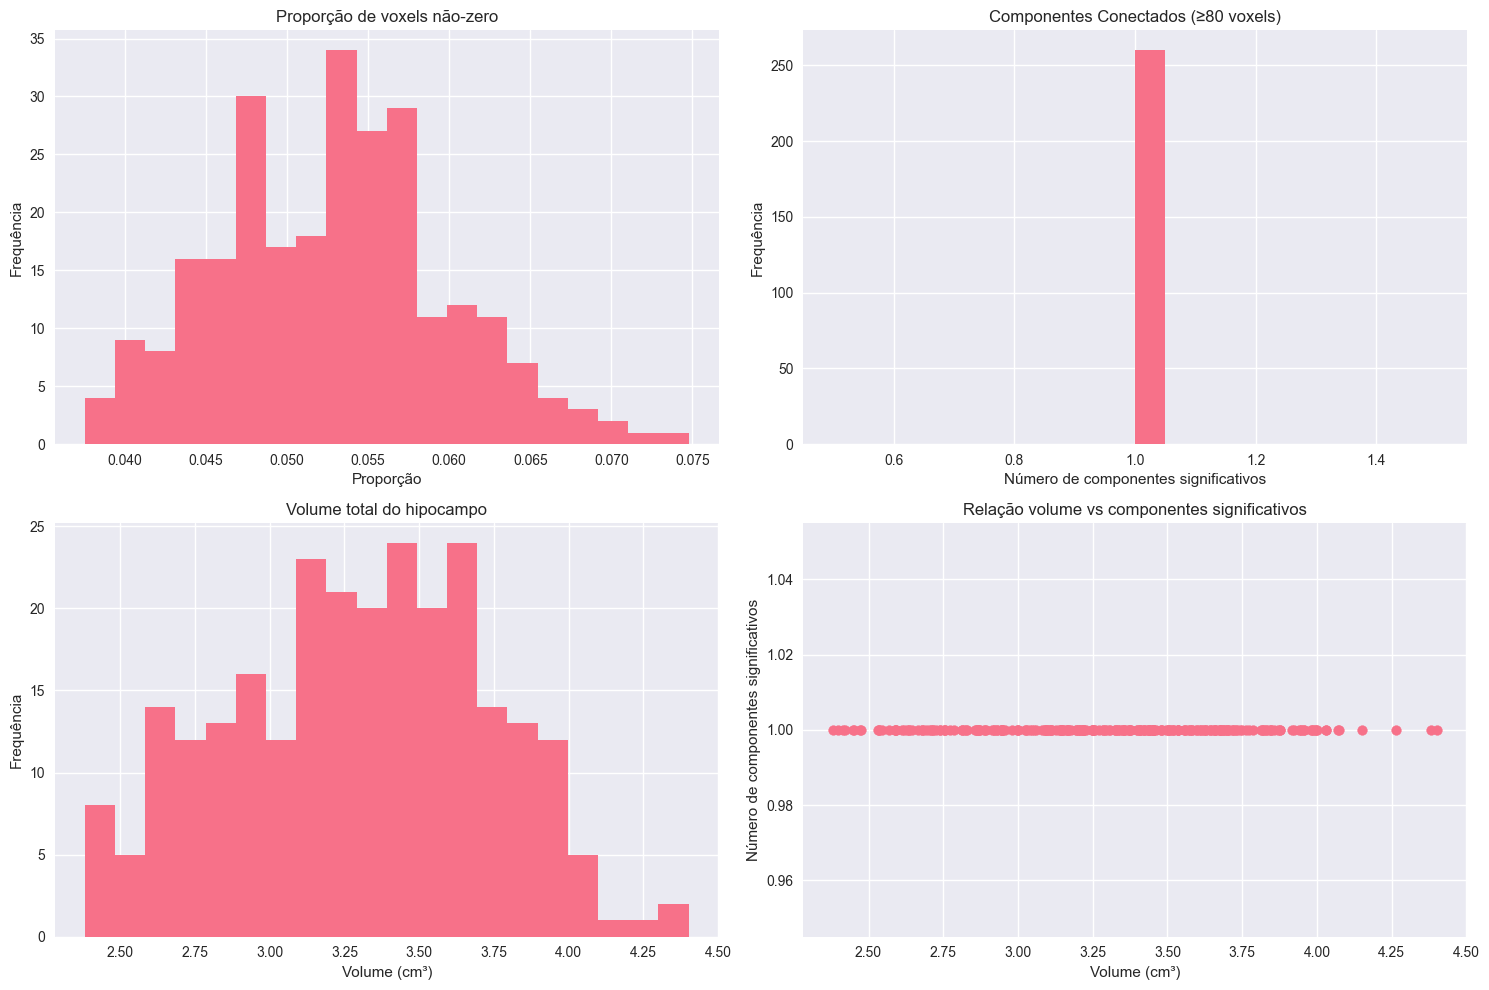


ANÁLISE DE QUALIDADE DA ROTULAÇÃO (min_size=80):
Volume médio: 3.30 cm³
Desvio padrão do volume: 0.43 cm³
Média de componentes significativos: 1.0
✅ Nenhum problema encontrado com componentes significativos

7. VISUALIZAÇÃO DE EXEMPLOS...


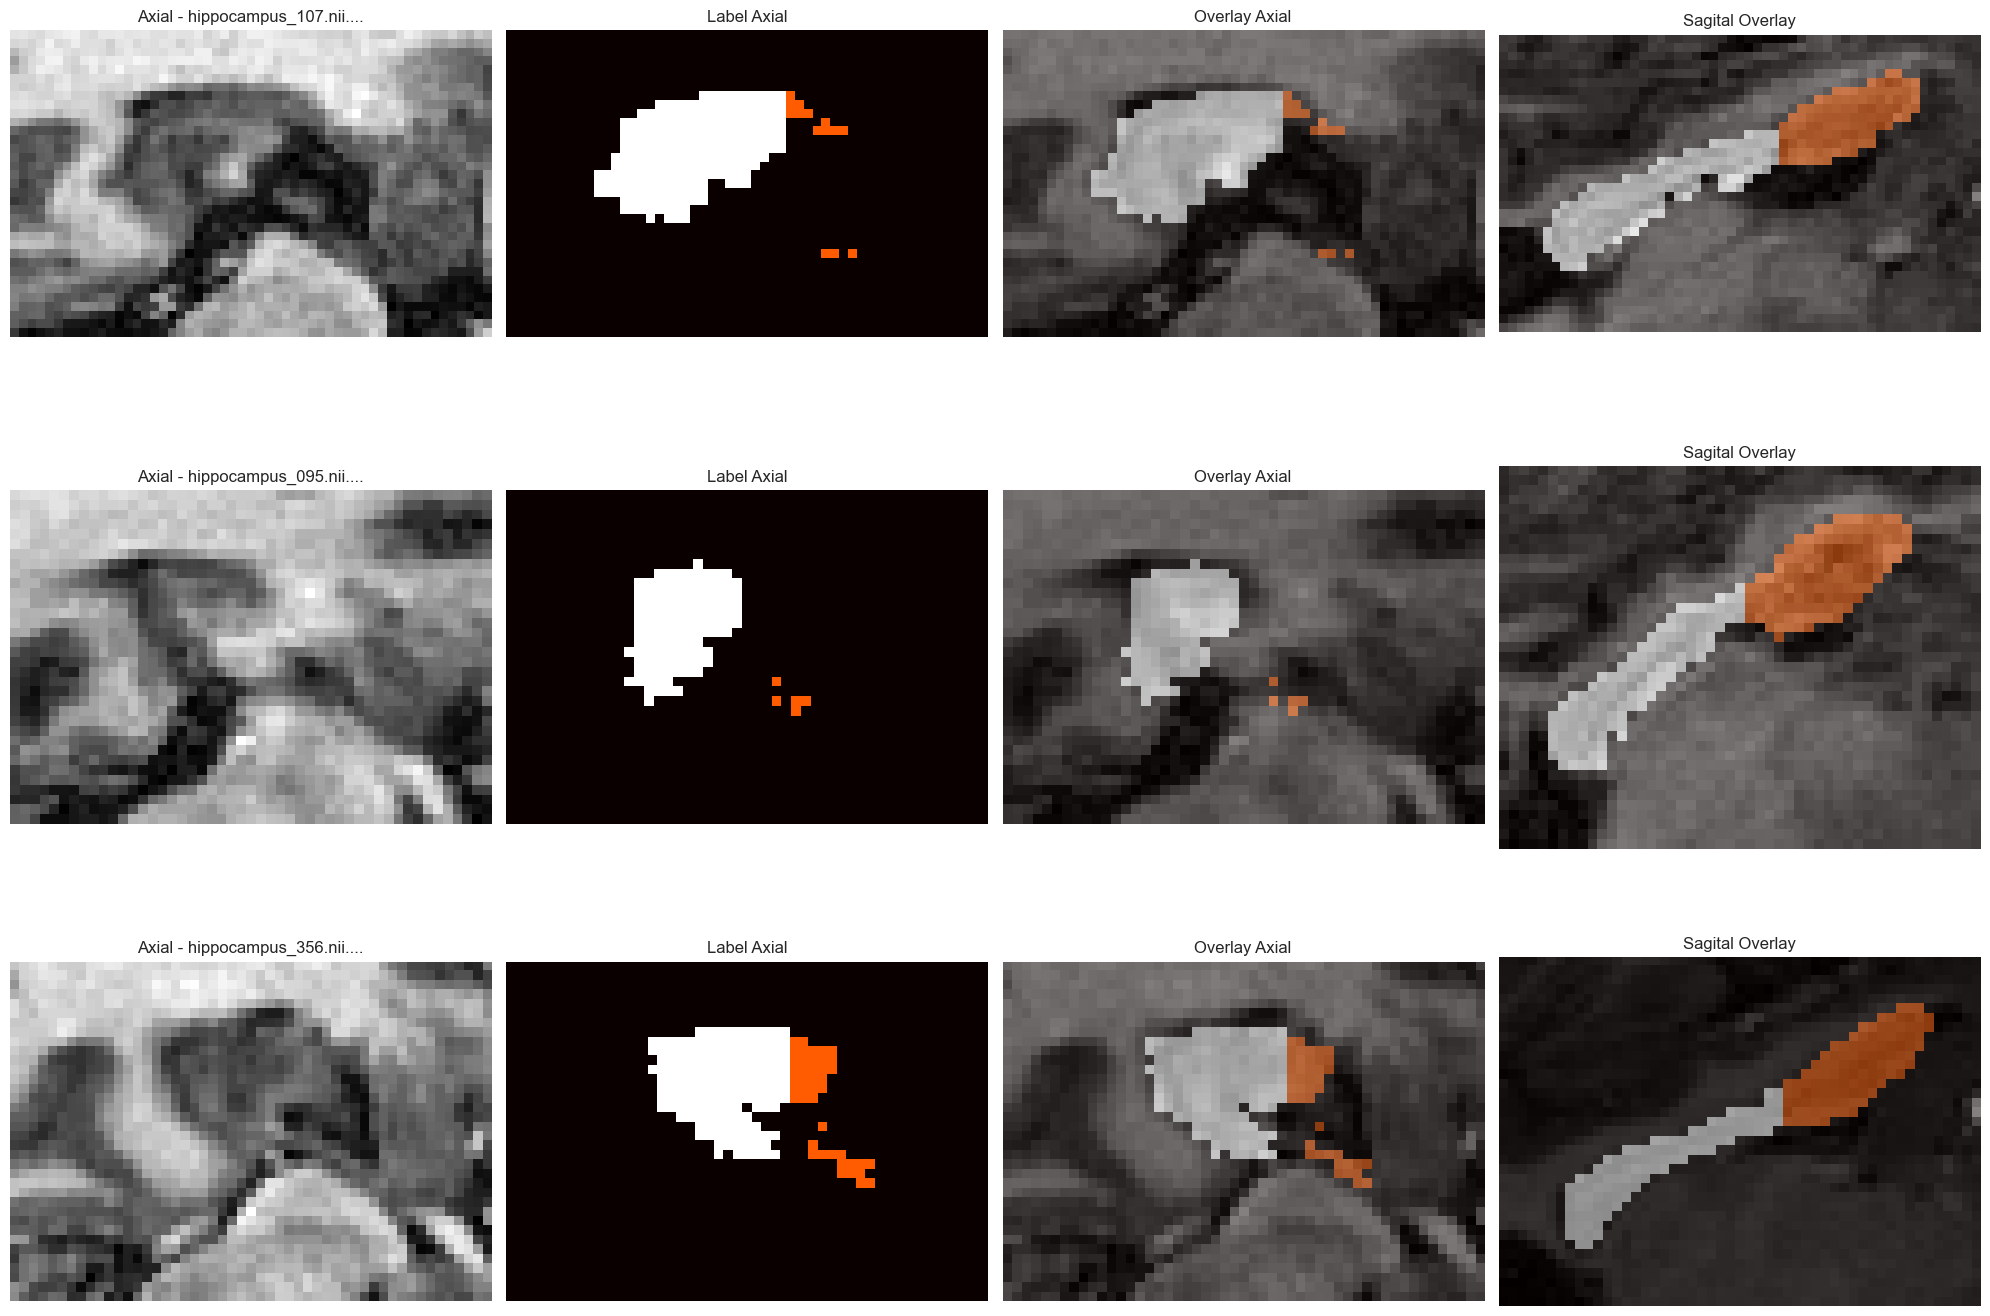

In [11]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy import ndimage
import re
from collections import defaultdict
import warnings
from scipy.ndimage import label as cc3d

# Configurações iniciais
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Suprimir warnings específicos
warnings.filterwarnings('ignore', category=UserWarning, message='.*SettingWithCopyWarning.*')
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

class NiftiEDA:
    def __init__(self, images_dir, labels_dir, min_component_size=80):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.min_component_size = min_component_size
        self.images = []
        self.labels = []
        self.metadata = []
        self.unmatched_images = []
        self.outliers_info = {}
        
    def binarize_and_clean(self, label_data, min_size=None):
        """Aplica limpeza de componentes pequenos como no seu teste"""
        if min_size is None:
            min_size = self.min_component_size
            
        # Binário (1 e 2 viram 1)
        B = (label_data > 0).astype(np.uint8)

        # Componentes conectados 3D (conectividade 6-neighborhood)
        structure = np.ones((3, 3, 3), dtype=bool)  # Conectividade 26
        cc, n = cc3d(B, structure=structure)
        
        # Remove ilhas pequenas
        keep = np.zeros_like(B, dtype=bool)
        component_sizes = []
        for k in range(1, n + 1):
            size = np.sum(cc == k)
            component_sizes.append(size)
            if size >= min_size:
                keep |= (cc == k)
                
        Bf = keep.astype(np.uint8)

        # Conta componentes após limpeza
        cc2, n2 = cc3d(Bf, structure=structure)
        
        return n, n2, component_sizes

    def find_matching_files(self):
        """Encontra arquivos correspondentes entre imagens e labels"""
        image_files = sorted([f for f in os.listdir(self.images_dir) 
                      if f.endswith(('.nii', '.nii.gz'))])
        label_files = sorted([f for f in os.listdir(self.labels_dir) 
                      if f.endswith(('.nii', '.nii.gz'))])
        
        print(f"Encontrados {len(image_files)} arquivos de imagem")
        print(f"Encontrados {len(label_files)} arquivos de label")
        
        matched_pairs = []
        unmatched_images = []
        
        for img_file in image_files:
            base_name = img_file.replace('.nii.gz', '').replace('.nii', '')
            
            possible_label_names = [
                base_name + '_label.nii.gz',
                base_name + '_seg.nii.gz',
                base_name + '.nii.gz',
                base_name.replace('image', 'label') + '.nii.gz',
                base_name.replace('img', 'label') + '.nii.gz',
                'label_' + base_name + '.nii.gz',
                base_name + '_mask.nii.gz',
            ]
            
            matched_label = None
            for label_candidate in possible_label_names:
                if label_candidate in label_files:
                    matched_label = label_candidate
                    break
            
            if not matched_label:
                img_numbers = re.findall(r'\d+', base_name)
                for label_file in label_files:
                    label_numbers = re.findall(r'\d+', label_file)
                    if img_numbers and label_numbers and set(img_numbers) == set(label_numbers):
                        matched_label = label_file
                        break
            
            if matched_label:
                matched_pairs.append((img_file, matched_label))
            else:
                unmatched_images.append(img_file)
        
        self.unmatched_images = unmatched_images
        
        # Mostrar resumo do matching
        print(f"✓ Pares encontrados: {len(matched_pairs)}")
        print(f"✗ Imagens sem label: {len(unmatched_images)}")
        
        return matched_pairs
    
    def load_data(self):
        """Carrega pares correspondentes de imagens e labels"""
        matched_pairs = self.find_matching_files()
        
        if len(self.unmatched_images) > 0:
            print(f"\nIMAGENS SEM LABEL ENCONTRADAS:")
            for img in self.unmatched_images:
                print(f"  - {img}")
        
        if len(matched_pairs) == 0:
            print("AVISO: Nenhum par imagem-label foi encontrado!")
            return
        
        print(f"\nCarregando {len(matched_pairs)} pares...")
        
        for img_file, label_file in matched_pairs:
            try:
                # Carrega imagem
                img_path = os.path.join(self.images_dir, img_file)
                img_nib = nib.load(img_path)
                img_data = img_nib.get_fdata()
                
                # Carrega label
                label_path = os.path.join(self.labels_dir, label_file)
                label_nib = nib.load(label_path)
                label_data = label_nib.get_fdata()
                
                # Armazena informações
                self.images.append({
                    'filename': img_file,
                    'data': img_data,
                    'affine': img_nib.affine,
                    'header': img_nib.header,
                    'shape': img_data.shape,
                    'voxel_dims': img_nib.header.get_zooms()
                })
                
                self.labels.append({
                    'filename': label_file,
                    'data': label_data,
                    'affine': label_nib.affine,
                    'header': label_nib.header,
                    'shape': label_data.shape,
                    'voxel_dims': label_nib.header.get_zooms(),
                    'paired_image': img_file
                })
                
            except Exception as e:
                print(f"Erro ao carregar par {img_file} - {label_file}: {e}")
    
    def extract_metadata(self):
        """Extrai metadados das imagens e labels"""
        self.metadata = []
        
        # Metadados das imagens
        for img_info in self.images:
            data = img_info['data']
            metadata = {
                'filename': img_info['filename'],
                'type': 'image',
                'shape': img_info['shape'],
                'dtype': data.dtype,
                'voxel_dims': img_info['voxel_dims'],
                'data_range': (np.min(data), np.max(data)),
                'mean_intensity': np.mean(data),
                'std_intensity': np.std(data)
            }
            self.metadata.append(metadata)
        
        # Metadados dos labels
        for label_info in self.labels:
            data = label_info['data']
            unique, counts = np.unique(data, return_counts=True)
            
            volume_mm3 = np.sum(data > 0) * np.prod(label_info['voxel_dims'])
            
            # Aplica limpeza de componentes pequenos
            n_raw, n_clean, component_sizes = self.binarize_and_clean(data)
            
            metadata = {
                'filename': label_info['filename'],
                'type': 'label', 
                'shape': label_info['shape'],
                'dtype': data.dtype,
                'voxel_dims': label_info['voxel_dims'],
                'unique_labels': unique,
                'label_counts': counts,
                'total_voxels': data.size,
                'nonzero_voxels': np.sum(data > 0),
                'volume_mm3': volume_mm3,
                'volume_cm3': volume_mm3 / 1000,
                'proportion_nonzero': np.sum(data > 0) / data.size,
                'componentes_raw': n_raw,
                'componentes_limpos': n_clean,
                'tamanho_componentes': component_sizes
            }
            self.metadata.append(metadata)

    def identificar_outliers(self):
        """Identifica outliers baseado nos critérios dos gráficos"""
        print("\n" + "="*80)
        print("IDENTIFICAÇÃO DE OUTLIERS")
        print("="*80)
        
        df_meta = pd.DataFrame(self.metadata)
        df_images = df_meta[df_meta['type'] == 'image'].copy()
        df_labels = df_meta[df_meta['type'] == 'label'].copy()
        
        self.outliers_info = {}
        
        # 0. OUTLIERS POR FALTA DE LABEL (CRÍTICO)
        if self.unmatched_images:
            for img_file in self.unmatched_images:
                if img_file not in self.outliers_info:
                    self.outliers_info[img_file] = []
                self.outliers_info[img_file].append("SEM LABEL - Imagem não tem label correspondente")
        
        # 1. Outliers de Dimensão X (> 200 voxels)
        df_images.loc[:, 'dim_x'] = df_images['shape'].apply(lambda x: x[0])
        dim_x_threshold = 200
        outliers_x = df_images[df_images['dim_x'] > dim_x_threshold]
        for _, row in outliers_x.iterrows():
            if row['filename'] not in self.outliers_info:
                self.outliers_info[row['filename']] = []
            self.outliers_info[row['filename']].append(f"DIMENSÃO X MUITO GRANDE: {row['dim_x']} voxels (threshold: {dim_x_threshold})")
        
        # 2. Outliers de Dimensão Y (> 200 voxels)
        df_images.loc[:, 'dim_y'] = df_images['shape'].apply(lambda x: x[1])
        dim_y_threshold = 200
        outliers_y = df_images[df_images['dim_y'] > dim_y_threshold]
        for _, row in outliers_y.iterrows():
            if row['filename'] not in self.outliers_info:
                self.outliers_info[row['filename']] = []
            self.outliers_info[row['filename']].append(f"DIMENSÃO Y MUITO GRANDE: {row['dim_y']} voxels (threshold: {dim_y_threshold})")
        
        # 3. Outliers de Dimensão Z (> 100 voxels)
        df_images.loc[:, 'dim_z'] = df_images['shape'].apply(lambda x: x[2])
        dim_z_threshold = 100
        outliers_z = df_images[df_images['dim_z'] > dim_z_threshold]
        for _, row in outliers_z.iterrows():
            if row['filename'] not in self.outliers_info:
                self.outliers_info[row['filename']] = []
            self.outliers_info[row['filename']].append(f"DIMENSÃO Z MUITO GRANDE: {row['dim_z']} voxels (threshold: {dim_z_threshold})")
        
        # 4. Outliers de Voxel Size (anisotrópicos)
        for _, row in df_images.iterrows():
            voxel_dims = row['voxel_dims'][:3]
            if len(voxel_dims) >= 3:
                anisotropy = max(voxel_dims) / min(voxel_dims)
                if anisotropy > 1.5:
                    if row['filename'] not in self.outliers_info:
                        self.outliers_info[row['filename']] = []
                    self.outliers_info[row['filename']].append(f"VOXEL ANISOTRÓPICO: {voxel_dims} mm (razão: {anisotropy:.2f})")
        
        # 5. Outliers de Volume do Hipocampo (> 15 cm³)
        volume_threshold = 15  # cm³
        outliers_volume = df_labels[df_labels['volume_cm3'] > volume_threshold]
        for _, row in outliers_volume.iterrows():
            # Encontrar a imagem correspondente
            img_filename = None
            for label_info in self.labels:
                if label_info['filename'] == row['filename']:
                    img_filename = label_info['paired_image']
                    break
            
            if img_filename and img_filename not in self.outliers_info:
                self.outliers_info[img_filename] = []
            if img_filename:
                self.outliers_info[img_filename].append(f"VOLUME ANORMAL: {row['volume_cm3']:.2f} cm³ (threshold: {volume_threshold} cm³)")
        
        # 6. Outliers de Proporção de Voxels
        df_labels.loc[:, 'proportion'] = df_labels['proportion_nonzero']
        Q1 = df_labels['proportion'].quantile(0.25)
        Q3 = df_labels['proportion'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_prop = df_labels[
            (df_labels['proportion'] < lower_bound) | 
            (df_labels['proportion'] > upper_bound)
        ]
        
        for _, row in outliers_prop.iterrows():
            # Encontrar a imagem correspondente
            img_filename = None
            for label_info in self.labels:
                if label_info['filename'] == row['filename']:
                    img_filename = label_info['paired_image']
                    break
            
            if img_filename and img_filename not in self.outliers_info:
                self.outliers_info[img_filename] = []
            if img_filename:
                self.outliers_info[img_filename].append(f"PROPORÇÃO ATÍPICA: {row['proportion']:.4f} (faixa normal: [{lower_bound:.4f}, {upper_bound:.4f}])")
        
        # 7. Outliers de Componentes Conectados (APÓS LIMPEZA)
        component_threshold = 1  # Mais de 1 componente significativo
        outliers_components = df_labels[df_labels['componentes_limpos'] > component_threshold]
        
        print(f"\n🔍 ANÁLISE DE COMPONENTES CONECTADOS (após limpeza com min_size={self.min_component_size})")
        print("-" * 60)
        
        for _, row in outliers_components.iterrows():
            img_filename = None
            for label_info in self.labels:
                if label_info['filename'] == row['filename']:
                    img_filename = label_info['paired_image']
                    break
            
            if img_filename:
                if img_filename not in self.outliers_info:
                    self.outliers_info[img_filename] = []
                
                # Analisar os tamanhos dos componentes
                component_sizes = row['tamanho_componentes']
                significant_components = [size for size in component_sizes if size >= self.min_component_size]
                
                self.outliers_info[img_filename].append(
                    f"MÚLTIPLOS COMPONENTES: {row['componentes_limpos']} componentes significativos "
                    f"(≥{self.min_component_size} voxels) - Tamanhos: {significant_components}"
                )
                
                print(f"  {row['filename']}: {row['componentes_raw']} → {row['componentes_limpos']} componentes "
                      f"(tamanhos: {significant_components})")
        
        # 8. Análise específica da imagem 195
        if 'hippocampus_195.nii.gz' in [img['filename'] for img in self.images]:
            self.analisar_imagem_195()
        
        # Mostrar resultados
        self.mostrar_outliers_detectados()
        
        return self.outliers_info

    def analisar_imagem_195(self):
        """Análise específica da imagem hippocampus_195.nii.gz"""
        print("\n🔍 ANÁLISE ESPECÍFICA: hippocampus_195.nii.gz")
        print("-" * 50)
        
        # Encontrar a imagem 195
        img_195 = None
        label_195 = None
        
        for img_info in self.images:
            if img_info['filename'] == 'hippocampus_195.nii.gz':
                img_195 = img_info
                break
        
        for label_info in self.labels:
            if label_info['paired_image'] == 'hippocampus_195.nii.gz':
                label_195 = label_info
                break
        
        if img_195 and label_195:
            # Análise detalhada
            img_data = img_195['data']
            label_data = label_195['data']
            
            print(f"Dimensões da imagem: {img_195['shape']}")
            print(f"Dimensões do label: {label_195['shape']}")
            print(f"Voxel size: {img_195['voxel_dims'][:3]} mm")
            
            # Verificar alinhamento
            if img_195['shape'] != label_195['shape']:
                print("❌ PROBLEMA: Dimensões não coincidem!")
            
            # Verificar volume do hipocampo
            volume_mm3 = np.sum(label_data > 0) * np.prod(label_195['voxel_dims'])
            volume_cm3 = volume_mm3 / 1000
            print(f"Volume do hipocampo: {volume_cm3:.2f} cm³")
            
            # Verificar proporção
            proportion = np.sum(label_data > 0) / label_data.size
            print(f"Proporção de voxels: {proportion:.4f}")
            
            # Verificar componentes conectados (com limpeza)
            n_raw, n_clean, component_sizes = self.binarize_and_clean(label_data)
            print(f"Componentes conectados: {n_raw} → {n_clean} (após limpeza)")
            print(f"Tamanhos dos componentes: {component_sizes}")
            
            # Verificar valores únicos no label
            unique_vals = np.unique(label_data)
            print(f"Valores únicos no label: {unique_vals}")
            
            # Adicionar aos outliers se necessário
            if 'hippocampus_195.nii.gz' not in self.outliers_info:
                self.outliers_info['hippocampus_195.nii.gz'] = []
            
            # Critérios específicos para a 195
            if volume_cm3 > 15:
                self.outliers_info['hippocampus_195.nii.gz'].append(f"VOLUME MUITO ALTO: {volume_cm3:.2f} cm³")
            if proportion > 0.1:
                self.outliers_info['hippocampus_195.nii.gz'].append(f"PROPORÇÃO ALTA: {proportion:.4f}")
            if img_195['shape'] != label_195['shape']:
                self.outliers_info['hippocampus_195.nii.gz'].append(f"ALINHAMENTO: imagem {img_195['shape']} vs label {label_195['shape']}")
            if n_clean > 1:
                self.outliers_info['hippocampus_195.nii.gz'].append(f"MÚLTIPLOS COMPONENTES: {n_clean} componentes significativos")
            
            if not self.outliers_info['hippocampus_195.nii.gz']:
                print("✅ hippocampus_195.nii.gz parece normal nos critérios básicos")
            else:
                print("❌ hippocampus_195.nii.gz identificada como outlier")

    def mostrar_outliers_detectados(self):
        """Mostra todos os outliers detectados de forma organizada"""
        total_outliers = len(self.outliers_info)
        
        print(f"\n📊 RESUMO DE OUTLIERS: {total_outliers} arquivos problemáticos")
        print("="*80)
        
        if not self.outliers_info:
            print("✅ Nenhum outlier crítico detectado. Dataset está limpo!")
            return
        
        # Ordenar por nome do arquivo
        sorted_outliers = sorted(self.outliers_info.items())
        
        for filename, motivos in sorted_outliers:
            print(f"\n🔴 {filename}")
            print("   Motivos:")
            for motivo in motivos:
                print(f"   • {motivo}")
        
        # Estatísticas
        print(f"\n📈 ESTATÍSTICAS DOS OUTLIERS:")
        print(f"   • Total de arquivos problemáticos: {total_outliers}")
        print(f"   • Arquivos limpos: {len(self.images) - total_outliers}")
        print(f"   • Eficiência do dataset: {(len(self.images) - total_outliers) / len(self.images) * 100:.1f}%")
        print(f"   • Limite de tamanho de componente: {self.min_component_size} voxels")
        
        # Recomendações específicas
        self.gerar_recomendacoes_especificas()

    def gerar_recomendacoes_especificas(self):
        """Gera recomendações específicas baseadas nos outliers encontrados"""
        print(f"\n🎯 RECOMENDAÇÕES PARA EXCLUSÃO")
        print("="*80)
        
        arquivos_para_excluir = []
        
        for filename, motivos in self.outliers_info.items():
            # Critérios para exclusão definitiva
            exclusao_definitiva = any([
                "SEM LABEL" in motivo for motivo in motivos
            ])
            
            if exclusao_definitiva:
                arquivos_para_excluir.append((filename, "EXCLUSÃO DEFINITIVA - Sem label"))
            else:
                # Avaliar gravidade dos outros problemas
                gravidade = len(motivos)
                if gravidade >= 2:
                    arquivos_para_excluir.append((filename, f"EXCLUSÃO RECOMENDADA - {gravidade} problemas"))
                else:
                    arquivos_para_excluir.append((filename, "ANÁLISE MANUAL - Problema isolado"))
        
        print("📋 LISTA DE AÇÕES RECOMENDADAS:")
        print("-" * 50)
        
        for arquivo, acao in arquivos_para_excluir:
            print(f"   {arquivo}")
            print(f"   └── {acao}")
            if "hippocampus_195.nii.gz" in arquivo:
                print(f"       └── 💡 Sugestão: Verificar manualmente o alinhamento imagem-label")
        
        print(f"\n💡 RESUMO DAS AÇÕES:")
        print(f"   • Exclusão definitiva: {len([a for a in arquivos_para_excluir if 'DEFINITIVA' in a[1]])} arquivos")
        print(f"   • Exclusão recomendada: {len([a for a in arquivos_para_excluir if 'RECOMENDADA' in a[1]])} arquivos")
        print(f"   • Análise manual: {len([a for a in arquivos_para_excluir if 'MANUAL' in a[1]])} arquivos")

    def plot_distribuicao_dimensoes_com_outliers(self):
        """Plota distribuição destacando os outliers"""
        if not self.metadata:
            return None
            
        df_meta = pd.DataFrame(self.metadata)
        df_images = df_meta[df_meta['type'] == 'image'].copy()
        df_labels = df_meta[df_meta['type'] == 'label'].copy()
        
        if len(df_images) == 0 or len(df_labels) == 0:
            return df_meta
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Preparar dados para highlight de outliers
        outlier_files = set(self.outliers_info.keys())
        
        # Dimensões X, Y, Z
        for i, dim_name in enumerate(['X', 'Y', 'Z']):
            df_images.loc[:, f'shape_{i}'] = df_images['shape'].apply(lambda x: x[i])
            df_labels.loc[:, f'shape_{i}'] = df_labels['shape'].apply(lambda x: x[i])
            
            # Separar outliers
            df_images_outliers = df_images[df_images['filename'].isin(outlier_files)]
            df_images_clean = df_images[~df_images['filename'].isin(outlier_files)]
            
            # Plot
            axes[0, i].hist(df_images_clean[f'shape_{i}'], alpha=0.7, label='Imagens Normais', bins=15, color='blue')
            if len(df_images_outliers) > 0:
                axes[0, i].hist(df_images_outliers[f'shape_{i}'], alpha=0.8, label='Outliers', bins=15, color='red')
            axes[0, i].hist(df_labels[f'shape_{i}'], alpha=0.5, label='Labels', bins=15, color='green')
            
            axes[0, i].set_title(f'Dimensão {dim_name}')
            axes[0, i].set_xlabel(f'Dimensão {dim_name} (voxels)')
            axes[0, i].set_ylabel('Frequência')
            axes[0, i].legend()
        
        # Resolução dos voxels
        voxel_dims_clean = []
        voxel_dims_outliers = []
        
        for _, row in df_images.iterrows():
            if row['filename'] in outlier_files:
                voxel_dims_outliers.extend(row['voxel_dims'][:3])
            else:
                voxel_dims_clean.extend(row['voxel_dims'][:3])
        
        axes[1, 0].hist(voxel_dims_clean, alpha=0.7, label='Normais', bins=20, color='blue')
        if voxel_dims_outliers:
            axes[1, 0].hist(voxel_dims_outliers, alpha=0.8, label='Outliers', bins=20, color='red')
        axes[1, 0].set_title('Tamanho dos Voxels')
        axes[1, 0].set_xlabel('Tamanho do voxel (mm)')
        axes[1, 0].set_ylabel('Frequência')
        axes[1, 0].legend()
        
        # Volume do hipocampo
        if 'volume_cm3' in df_labels.columns:
            df_labels_clean = df_labels[~df_labels['filename'].isin(outlier_files)]
            df_labels_outliers = df_labels[df_labels['filename'].isin(outlier_files)]
            
            axes[1, 1].hist(df_labels_clean['volume_cm3'], bins=20, alpha=0.7, color='blue', label='Normais')
            if len(df_labels_outliers) > 0:
                axes[1, 1].hist(df_labels_outliers['volume_cm3'], bins=20, alpha=0.8, color='red', label='Outliers')
            axes[1, 1].set_title('Volume do Hipocampo')
            axes[1, 1].set_xlabel('Volume (cm³)')
            axes[1, 1].set_ylabel('Frequência')
            axes[1, 1].legend()
        
        # Proporção de voxels não-zero
        if 'proportion_nonzero' in df_labels.columns:
            axes[1, 2].hist(df_labels_clean['proportion_nonzero'], bins=20, alpha=0.7, color='blue', label='Normais')
            if len(df_labels_outliers) > 0:
                axes[1, 2].hist(df_labels_outliers['proportion_nonzero'], bins=20, alpha=0.8, color='red', label='Outliers')
            axes[1, 2].set_title('Proporção de Voxels')
            axes[1, 2].set_xlabel('Proporção de voxels não-zero')
            axes[1, 2].set_ylabel('Frequência')
            axes[1, 2].legend()
        
        plt.tight_layout()
        plt.show()
        
        return df_meta

    def analisar_intensidades(self):
        """Analisa a distribuição de intensidades das imagens"""
        if len(self.images) == 0:
            print("Nenhuma imagem disponível para análise de intensidades")
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Distribuição de intensidades de todas as imagens
        all_intensities = []
        for img_info in self.images:
            data = img_info['data'].flatten()
            # Amostra para não sobrecarregar a memória
            if len(data) > 100000:
                data = np.random.choice(data, 100000, replace=False)
            all_intensities.extend(data)
        
        axes[0, 0].hist(all_intensities, bins=100, alpha=0.7)
        axes[0, 0].set_title('Distribuição de Intensidades - Todas as imagens')
        axes[0, 0].set_xlabel('Intensidade')
        axes[0, 0].set_ylabel('Frequência')
        
        # Distribuição por imagem individual (primeiras 6)
        sample_data = []
        filenames = []
        for i, img_info in enumerate(self.images[:6]):
            data = img_info['data'].flatten()
            if len(data) > 50000:
                data = np.random.choice(data, 50000, replace=False)
            sample_data.append(data)
            filenames.append(f"Img{i+1}")
        
        axes[0, 1].boxplot(sample_data, labels=filenames)
        axes[0, 1].set_title('Distribuição de Intensidades por imagem')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Análise dos valores dos labels
        if len(self.labels) > 0:
            label_values = []
            for label_info in self.labels:
                unique_vals = np.unique(label_info['data'])
                label_values.extend(unique_vals)
            
            axes[1, 0].hist(label_values, bins=20, alpha=0.7, color='red')
            axes[1, 0].set_title('Valores únicos encontrados nos labels')
            axes[1, 0].set_xlabel('Valor do label')
            axes[1, 0].set_ylabel('Frequência')
            
            # Proporção de classes
            class_distribution = defaultdict(int)
            for label_info in self.labels:
                unique, counts = np.unique(label_info['data'], return_counts=True)
                for val, count in zip(unique, counts):
                    class_distribution[val] += count
            
            classes = list(class_distribution.keys())
            counts = list(class_distribution.values())
            
            axes[1, 1].bar(classes, counts, alpha=0.7, color='green')
            axes[1, 1].set_title('Distribuição global das classes')
            axes[1, 1].set_xlabel('Classe')
            axes[1, 1].set_ylabel('Total de voxels')
            
            print("Distribuição das classes nos labels:")
            for cls, count in sorted(class_distribution.items()):
                print(f"  Classe {cls}: {count} voxels")
        
        plt.tight_layout()
        plt.show()

    def verificar_alinhamento(self):
        """Verifica o alinhamento entre imagens e labels correspondentes"""
        if len(self.images) != len(self.labels):
            print(f"AVISO: Número de imagens ({len(self.images)}) e labels ({len(self.labels)}) não corresponde!")
            return []
        
        misalignment_info = []
        
        for img_info, label_info in zip(self.images, self.labels):
            img_shape = img_info['shape']
            label_shape = label_info['shape']
            
            if img_shape != label_shape:
                misalignment_info.append({
                    'image': img_info['filename'],
                    'label': label_info['filename'],
                    'img_shape': img_shape,
                    'label_shape': label_shape,
                    'match': False
                })
            else:
                misalignment_info.append({
                    'image': img_info['filename'],
                    'label': label_info['filename'], 
                    'img_shape': img_shape,
                    'label_shape': label_shape,
                    'match': True
                })
        
        # Estatísticas de alinhamento
        matches = [info['match'] for info in misalignment_info]
        match_rate = np.mean(matches) if matches else 0
        
        print(f"Taxa de alinhamento: {match_rate*100:.1f}% ({sum(matches)}/{len(matches)} pares)")
        
        if not all(matches):
            print("\nPARES COM PROBLEMAS DE ALINHAMENTO:")
            for info in misalignment_info:
                if not info['match']:
                    print(f"Imagem: {info['image']} - Shape: {info['img_shape']}")
                    print(f"Label:  {info['label']} - Shape: {info['label_shape']}")
                    print("---")
        else:
            print("✓ Todos os pares estão perfeitamente alinhados!")
        
        return misalignment_info

    def visualizar_slices_aleatorios(self, n_samples=3):
        """Visualiza slices aleatórios de imagens e labels"""
        if len(self.images) == 0:
            print("Nenhuma imagem carregada para visualização")
            return
        
        fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5*n_samples))
        
        if n_samples == 1:
            axes = axes.reshape(1, -1)
            
        for i in range(n_samples):
            idx = np.random.randint(0, len(self.images))
            
            img_data = self.images[idx]['data']
            label_data = self.labels[idx]['data']
            
            # Slices nos três planos
            slice_x = img_data.shape[0] // 2
            slice_y = img_data.shape[1] // 2
            slice_z = img_data.shape[2] // 2
            
            # Axial (Z)
            axes[i, 0].imshow(img_data[:, :, slice_z], cmap='gray')
            axes[i, 0].set_title(f'Axial - {self.images[idx]["filename"][:20]}...')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(label_data[:, :, slice_z], cmap='hot')
            axes[i, 1].set_title(f'Label Axial')
            axes[i, 1].axis('off')
            
            # Overlay
            axes[i, 2].imshow(img_data[:, :, slice_z], cmap='gray')
            axes[i, 2].imshow(label_data[:, :, slice_z], cmap='hot', alpha=0.5)
            axes[i, 2].set_title('Overlay Axial')
            axes[i, 2].axis('off')
            
            # Sagital (X)
            axes[i, 3].imshow(img_data[slice_x, :, :].T, cmap='gray')
            axes[i, 3].imshow(label_data[slice_x, :, :].T, cmap='hot', alpha=0.5)
            axes[i, 3].set_title('Sagital Overlay')
            axes[i, 3].axis('off')
            
        plt.tight_layout()
        plt.show()

    def analisar_qualidade_rotulacao(self):
        """Analisa a qualidade da rotulação com limpeza de componentes"""
        if len(self.labels) == 0:
            print("Nenhum label disponível para análise de qualidade")
            return None
            
        qualidade_info = []
        
        for label_info in self.labels:
            label_data = label_info['data']
            
            # Usa a limpeza de componentes
            n_raw, n_clean, component_sizes = self.binarize_and_clean(label_data)
            significant_components = [size for size in component_sizes if size >= self.min_component_size]
            
            # Calcula métricas de qualidade
            stats = {
                'filename': label_info['filename'],
                'total_voxels': label_data.size,
                'voxels_nao_zero': np.sum(label_data > 0),
                'proporcao_nao_zero': np.sum(label_data > 0) / label_data.size,
                'numero_componentes_raw': n_raw,
                'numero_componentes_limpos': n_clean,
                'componentes_significativos': len(significant_components),
                'volume_total_mm3': np.sum(label_data > 0) * np.prod(label_info['voxel_dims']),
            }
            
            qualidade_info.append(stats)
        
        df_qualidade = pd.DataFrame(qualidade_info)
        
        # Plot métricas de qualidade
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].hist(df_qualidade['proporcao_nao_zero'], bins=20)
        axes[0, 0].set_title('Proporção de voxels não-zero')
        axes[0, 0].set_xlabel('Proporção')
        axes[0, 0].set_ylabel('Frequência')
        
        # Agora plota componentes LIMPOS
        axes[0, 1].hist(df_qualidade['numero_componentes_limpos'], bins=20)
        axes[0, 1].set_title(f'Componentes Conectados (≥{self.min_component_size} voxels)')
        axes[0, 1].set_xlabel('Número de componentes significativos')
        axes[0, 1].set_ylabel('Frequência')
        
        axes[1, 0].hist(df_qualidade['volume_total_mm3'] / 1000, bins=20)
        axes[1, 0].set_title('Volume total do hipocampo')
        axes[1, 0].set_xlabel('Volume (cm³)')
        axes[1, 0].set_ylabel('Frequência')
        
        # Scatter plot: volume vs número de componentes LIMPOS
        axes[1, 1].scatter(df_qualidade['volume_total_mm3'] / 1000, 
                          df_qualidade['numero_componentes_limpos'])
        axes[1, 1].set_xlabel('Volume (cm³)')
        axes[1, 1].set_ylabel('Número de componentes significativos')
        axes[1, 1].set_title('Relação volume vs componentes significativos')
        
        plt.tight_layout()
        plt.show()
        
        # Identificar possíveis problemas - agora com componentes LIMPOS
        print(f"\nANÁLISE DE QUALIDADE DA ROTULAÇÃO (min_size={self.min_component_size}):")
        print(f"Volume médio: {df_qualidade['volume_total_mm3'].mean()/1000:.2f} cm³")
        print(f"Desvio padrão do volume: {df_qualidade['volume_total_mm3'].std()/1000:.2f} cm³")
        print(f"Média de componentes significativos: {df_qualidade['numero_componentes_limpos'].mean():.1f}")
        
        # Verificar outliers em componentes LIMPOS
        outliers_components = df_qualidade[df_qualidade['numero_componentes_limpos'] > 1]
        
        if len(outliers_components) > 0:
            print(f"\nPOSSÍVEIS PROBLEMAS ENCONTRADOS (componentes significativos):")
            for _, row in outliers_components.iterrows():
                print(f"  {row['filename']}: {row['numero_componentes_limpos']} componentes significativos")
        else:
            print(f"✅ Nenhum problema encontrado com componentes significativos")
        
        return df_qualidade

    def gerar_relatorio_completo(self):
        """Gera um relatório completo do EDA com identificação de outliers"""
        print("="*60)
        print(f"RELATÓRIO COMPLETO DE EDA - IMAGENS HIPOCAMPO (min_size={self.min_component_size})")
        print("="*60)
        
        # Carregar dados
        print("\n1. CARREGANDO DADOS...")
        self.load_data()
        
        if len(self.images) == 0:
            print("ERRO: Nenhuma imagem foi carregada. Verifique os caminhos.")
            return
        
        self.extract_metadata()
        
        print(f"\nRESUMO INICIAL:")
        print(f"Total de imagens carregadas: {len(self.images)}")
        print(f"Total de labels carregados: {len(self.labels)}")
        if self.unmatched_images:
            print(f"Imagens sem label: {len(self.unmatched_images)}")
        
        # Identificar outliers
        print("\n2. IDENTIFICANDO OUTLIERS...")
        outliers = self.identificar_outliers()
        
        # Análise de dimensões com outliers destacados
        print("\n3. ANÁLISE DE DIMENSÕES E RESOLUÇÃO...")
        df_meta = self.plot_distribuicao_dimensoes_com_outliers()
        
        # Só prosseguir com análises detalhadas se tivermos dados
        if len(self.images) > 0 and len(self.labels) > 0:
            # Verificar alinhamento
            print("\n4. VERIFICANDO ALINHAMENTO...")
            self.verificar_alinhamento()
            
            # Análise de intensidades
            print("\n5. ANÁLISE DE INTENSIDADES...")
            self.analisar_intensidades()
            
            # Qualidade da rotulação (AGORA COM LIMPEZA)
            print(f"\n6. ANÁLISE DA QUALIDADE DA ROTULAÇÃO (min_size={self.min_component_size})...")
            self.analisar_qualidade_rotulacao()
            
            # Visualização
            print("\n7. VISUALIZAÇÃO DE EXEMPLOS...")
            self.visualizar_slices_aleatorios(n_samples=3)

# Uso da classe
if __name__ == "__main__":
    # Caminhos das pastas
    images_directory = "/Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/images"
    labels_directory = "/Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/labels"
    
    # Executar análise com limpeza de componentes (80 voxels como no seu teste)
    eda = NiftiEDA(images_directory, labels_directory, min_component_size=80)
    eda.gerar_relatorio_completo()

### RESUMO DE OUTLIERS: 4 arquivos problemáticos
================================================================================

hippocampus_010.nii.gz
   
   Motivos:
   - DIMENSÃO X MUITO GRANDE: 512 voxels (threshold: 200)
   - DIMENSÃO Y MUITO GRANDE: 512 voxels (threshold: 200)
   - DIMENSÃO Z MUITO GRANDE: 241 voxels (threshold: 100)
   - VOXEL ANISOTRÓPICO: (0.597656, 0.597656, 1.25) mm (razão: 2.09)

hippocampus_118.nii.gz
   Motivos:
   - SEM LABEL - Imagem não tem label correspondente

hippocampus_195.nii.gz
   Motivos:
   - PROPORÇÃO ATÍPICA: 0.0748 (faixa normal: [0.0334, 0.0713])

hippocampus_281.nii.gz
   Motivos:
   - DIMENSÃO X MUITO GRANDE: 512 voxels (threshold: 200)
   - DIMENSÃO Y MUITO GRANDE: 512 voxels (threshold: 200)
   - VOXEL ANISOTRÓPICO: (0.785156, 0.785156, 7.5) mm (razão: 9.55)
   - VOLUME ANORMAL: 55.82 cm³ (threshold: 15 cm³)
   = PROPORÇÃO ATÍPICA: 0.0008 (faixa normal: [0.0334, 0.0713])

ESTATÍSTICAS DOS OUTLIERS:
   - Total de arquivos problemáticos: 4
   - Arquivos limpos: 258
   - Eficiência do dataset: 98.5%

💡 RESUMO DAS AÇÕES:
   - Exclusão definitiva: 1 arquivos
   - Exclusão recomendada: 2 arquivos
   - Análise manual: 1 arquivos

Although hippocampus_195.nii.gz was flagged as an outlier due to slightly atypical voxel proportions and hippocampal volume, we performed a manual inspection in 3D Slicer. By importing the segmentation as a labelmap and overlaying it on the MRI, we confirmed that the region correctly corresponds to the hippocampus and does not include extra tissue. Therefore, we decided to keep this sample in the dataset.

In [8]:
import os
import shutil

# Diretórios
base_dir = "/Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")
excluded_dir = os.path.join(base_dir, "excluded")

# Criar pasta de exclusão se não existir
os.makedirs(os.path.join(excluded_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(excluded_dir, "labels"), exist_ok=True)

# Lista de arquivos a remover
to_exclude_both = ["hippocampus_010.nii.gz", "hippocampus_281.nii.gz"]
to_exclude_images = ["hippocampus_118.nii.gz"]

# Função para mover arquivos
def move_file(src_dir, dst_dir, filename):
    src = os.path.join(src_dir, filename)
    dst = os.path.join(dst_dir, filename)
    if os.path.exists(src):
        shutil.move(src, dst)
        print(f"Moved: {src} → {dst}")
    else:
        print(f"File not found: {src}")

# Mover imagens + labels
for fname in to_exclude_both:
    move_file(images_dir, os.path.join(excluded_dir, "images"), fname)
    move_file(labels_dir, os.path.join(excluded_dir, "labels"), fname)

# Mover só imagem (sem label correspondente)
for fname in to_exclude_images:
    move_file(images_dir, os.path.join(excluded_dir, "images"), fname)

print("✅ Cleanup complete. Problematic files moved to 'excluded/'")


Moved: /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/images/hippocampus_010.nii.gz → /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/excluded/images/hippocampus_010.nii.gz
Moved: /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/labels/hippocampus_010.nii.gz → /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/excluded/labels/hippocampus_010.nii.gz
Moved: /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/images/hippocampus_281.nii.gz → /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/excluded/images/hippocampus_281.nii.gz
Moved: /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/labels/hippocampus_281.nii.gz → /Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/excluded/labels/hippocampus_281.nii.gz
Moved: /

Fundir classes (1 e 2 → 1) e medir componentes “úteis”

In [9]:
import nibabel as nib
import numpy as np
import os
from scipy.ndimage import label as cc3d

labels_dir = "/Users/edmundobrown/Documents/Alzheimer/nd320-c3-3d-imaging-starter/data/TrainingSet/labels"

def binarize_and_clean(label_path, min_size=50):
    lab = nib.load(label_path)
    L = lab.get_fdata()
    # binário (1 e 2 viram 1)
    B = (L > 0).astype(np.uint8)

    # componentes conectados 3D (conectividade 6-neighborhood)
    structure = np.zeros((3,3,3), dtype=int); structure[1,:,1]=1; structure[:,1,1]=1; structure[1,1,:]=1
    cc, n = cc3d(B, structure=structure)
    # remove ilhas pequenas
    keep = np.zeros_like(B, dtype=bool)
    for k in range(1, n+1):
        size = np.sum(cc==k)
        if size >= min_size:
            keep |= (cc==k)
    Bf = keep.astype(np.uint8)

    # conta componentes após limpeza
    cc2, n2 = cc3d(Bf, structure=structure)
    return B, Bf, n, n2

# exemplo rápido em um caso com 2 componentes da sua lista
test_case = "hippocampus_004.nii.gz"
_, Bf, n_raw, n_clean = binarize_and_clean(os.path.join(labels_dir, test_case), min_size=80)
print(test_case, "raw components:", n_raw, "| after min_size filter:", n_clean)


hippocampus_004.nii.gz raw components: 2 | after min_size filter: 1


### Rodando o EDA novamente para ver como ficou